In [1]:
import uproot
import matplotlib.pyplot as plt
import numpy as np
import mplhep as hep
import matplotlib as mpl
from matplotlib.cm import get_cmap
hep.style.use("CMS")
import hist as hist2
from hist.intervals import ratio_uncertainty
file_path = 'fitDiagnostics.plotsT.root'
#file_path = 'fitDiagnostics.plotsFULL.root'
file = uproot.open(file_path)
LUMI = {"2016APV": 19.52, "2016": 16.81, "2017": 41.48, "2018": 59.83,"Full-Run2":138}

In [11]:
widths = [20,20,20,20,20,40]
bin_width = widths
edges = [40,60,80,100,120,140,180]  

#bin_width = [30,40,30,40]
#widths = bin_width
#edges = [40,70,110,140,180]

errps = {    "hatch": "////",    "facecolor": "none", "lw": 0,  "color": "k", "edgecolor": (0, 0, 0, 0.5),   "linewidth": 1,   "alpha": 0.4,}
#shapes_fit_b = file["shapes_fit_s"]
shapes_fit_b = file["shapes_prefit"]

regions = ["SR1pass2016APV" ]  #CHANGE PER REGION

background_processes = [ "TTbar", "WJetsLNu",  "SingleTop", "DYJets",  "Diboson", 
                      # "WH",  "WH", "ZH", "ggF", "VBF", "ttH", 
                     #   "fake", NOTE: ADD IN FAKE ONLY FOR 2018 right now
                        "total_background","total", "total_signal"] 
colors = ["blue", 
          "green", "cyan", "orange",  "deepskyblue", "lime", "yellow", 
           "purple", "darkmagenta", "orchid", "deeppink", "hotpink",  "gray", "brown"]

histograms = {}

for region in regions:
    histograms[region] = {}
    # Retrieve all keys in the region and remove the ';1' suffix
    region_keys = {key.split(";")[0]: key for key in shapes_fit_b[region].keys()}
    for process in background_processes + ["data"]:  
        try:
            # Access the object using the stripped key
            obj = shapes_fit_b[f"{region}/{region_keys[process]}"]
            if obj.classname == "TGraphAsymmErrors":
                # Extract x (bin centers) and y (values) for TGraphAsymmErrors
                x_values = np.array(obj.member("fX"), dtype=np.float32)
                y_values = np.array(obj.member("fY"), dtype=np.float32)               
                y_values = y_values*widths   #MULTIPLYING BY BIN WIDTH
            elif obj.classname == "TH1F":
                # For TH1F, extract the bin centers and values directly
                y_values = obj.values()
                bin_edges = obj.axes[0].edges()
                x_values = (bin_edges[:-1] + bin_edges[1:]) / 2  # Calculate bin centers
                widths = obj.axes[0].widths()
                y_values = y_values*widths   #MULTIPLYING BY BIN WIDTH
            histograms[region][process] = (x_values, y_values)
            print('histos',  process, histograms[region][process])
        except KeyError:
            print(f"Process '{process}' not found in region '{region}'.")
        except Exception as e:
            print(f"Error accessing '{process}' in region '{region}': {e}")

histos TTbar (array([ 50.,  70.,  90., 110., 130., 160.]), array([ 5.76344371, 10.031389  , 16.46503329,  8.86418402,  6.11005247,
       10.78189731]))
histos WJetsLNu (array([ 50.,  70.,  90., 110., 130., 160.]), array([9.51785207, 6.75882936, 3.98476064, 6.62475228, 2.94102907,
       2.8057766 ]))
histos SingleTop (array([ 50.,  70.,  90., 110., 130., 160.]), array([0.59931967, 0.93462162, 1.43320858, 0.42243082, 0.09825894,
       0.1851603 ]))
histos DYJets (array([ 50.,  70.,  90., 110., 130., 160.]), array([1.29744887, 0.47499876, 0.56406442, 0.27764125, 0.31206168,
       0.19678501]))
histos Diboson (array([ 50.,  70.,  90., 110., 130., 160.]), array([0.53707011, 0.64684048, 0.35563193, 0.49782436, 0.12914317,
       0.20448996]))
histos total_background (array([ 50.,  70.,  90., 110., 130., 160.]), array([17.71513462, 18.84667993, 22.80269861, 16.6868329 ,  9.5905453 ,
       14.1741097 ]))
histos total (array([ 50.,  70.,  90., 110., 130., 160.]), array([17.93732166, 19.437

got total background
total bkg [17.71513462 18.84667993 22.80269861 16.6868329   9.5905453  14.1741097 ]
total [17.93732166 19.43758845 24.23094749 17.20642328  9.81814981 14.37456846]
total Ey [17.71513462 18.84667993 22.80269861 16.6868329   9.5905453  14.1741097 ]
total [17.93732166 19.43758845 24.23094749 17.20642328  9.81814981 14.37456846]
DataSum [17.71513343 18.84667993 22.80269861 16.6868329   9.59054589 14.1741097 ]
data_mc [0.98761308 0.9695997  0.94105683 0.96980253 0.97681804 0.98605462]


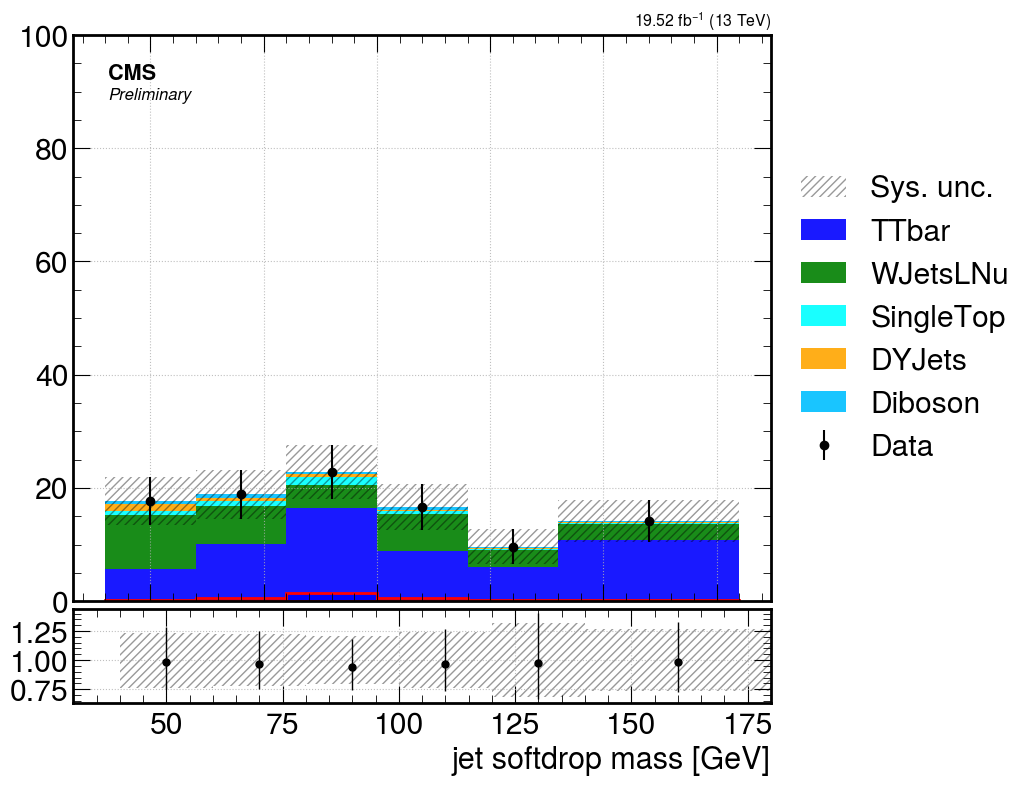

In [12]:
for region in regions: 
    f = plt.figure(figsize=(9, 10))
    #gs =mpl.gridspec.GridSpec(3, 1, height_ratios=[6, 1, 1], hspace=0.08)
    gs =mpl.gridspec.GridSpec(3, 1, height_ratios=[6, 1, 1], hspace=0.03)  #hsapce is space between plot and ratio plot
    ax = f.add_subplot(gs[0])
    plt.grid()
    #hep.cms.label(loc = 1, data=True, year=year, ax=ax, lumi=LUMI[year], fontsize=18, llabel='Preliminary')
    # Ratio panel
    ax1 = f.add_subplot(gs[1])
    ax1.grid() 
    bin_centers = histograms[region][background_processes[0]][0]
    #bin_width = bin_centers[1] - bin_centers[0]  # Assuming uniform bin width
    # Initialize an array to accumulate the stacked values
    cumulative_values = np.zeros_like(bin_centers)

    for i, process in enumerate(background_processes):
        if process == 'total_background':
            print('got total background')
            y_valuesB = histograms[region][process][1]
            print('total bkg', y_valuesB)
            continue
        if process == 'total':
            y_valuesT = histograms[region][process][1]
            print('total', y_valuesT)
            continue
        if process == 'total_signal':
            continue
        else:
            y_values = histograms[region][process][1]
            ax.bar(bin_centers, y_values, width=bin_width, bottom=cumulative_values,
                    color=colors[i % len(colors)], alpha=0.9, label=process, align='center')
            cumulative_values += y_values

    # Plot the data points as black markers with error bars, no connecting line
    if "data" in histograms[region]:
        ax.errorbar(histograms[region]["data"][0], histograms[region]["data"][1], 
                     yerr=np.sqrt(histograms[region]["data"][1]), fmt='o', color='black', label="Data")

 
    for i, process in enumerate(background_processes):
        if process == 'total_background':
        #if process == 'total':
            Ey_values =  histograms[region][process][1]
            #print('total Ey*widths', Ey_values*widths)  #CHECK THIS
            print('total Ey', Ey_values)  #CHECK THIS
            
        #    SR = np.sqrt(Ey_values*widths)  
            SR = np.sqrt(Ey_values)  

            
            ax.stairs(
                values=Ey_values +   SR,
                baseline=Ey_values -   SR,
                edges=edges,
                **errps,
                label="Sys. unc.",
            )

     #***********************************************
    for i, process in enumerate(background_processes):
        if process == 'total_signal':
            y_values = histograms[region][process][1]
            ax.bar(bin_centers, y_values, width=bin_width, 
           #         color=colors[i % len(colors)], alpha=0.9, label=process, align='center')
                    edgecolor='red',  alpha=1, label="_signal", align='center',   color='blue',linewidth=2)



    #for ratio plot************************************************************************
   # err_bkg = np.sqrt(arrays_var["TotalBkg"])
   # h_bkg = arrays["TotalBkg"]        
    for i, process in enumerate(background_processes):
        if process == 'total':
            TotalSum =  histograms[region][process][1]
            print('total', TotalSum)
        if process == 'data':
            print('TotalSum', TotalSum)           
    if "data" in histograms[region]:
        DataSum =  histograms[region]['data'][1]
        print('DataSum', DataSum)
    data_mc_ratio = (DataSum)/(TotalSum)
    print('data_mc', data_mc_ratio)

    hep.histplot((DataSum)/(TotalSum), bins=edges, yerr=ratio_uncertainty(DataSum,TotalSum,"poisson"), color='black', 
                 histtype='errorbar',
                 #density=density, 
                 stack=False, ax=ax1)    
    #err_bkg=np.sqrt(TotalSum*widths)
    err_bkg=np.sqrt(TotalSum)
    
    ax1.stairs(values = 1 + err_bkg/TotalSum, baseline = 1 - err_bkg/TotalSum, edges = edges, **errps)
  #END: for ratio plot************************************************************************

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))    
   # ax.tick_params(axis='both', which='major', labelsize=16)
    ax1.tick_params(axis='both', which='minor', labelsize=16)
    ax1.set_xlim(30, 180)
    ax1.set_xlabel('jet softdrop mass [GeV]', fontsize=22, ha='right', x=1)
    ax.set_ylim(0, 100,)
    #hep.cms.label(loc = 1, data=True, year='2018', ax=ax,  fontsize=15, llabel='Preliminary')
    hep.cms.label(loc = 2,  data =  True,  ax=ax, lumi=LUMI['2016APV'], fontsize=12, llabel='Preliminary' )
  
    plt.show()
